<a href="https://colab.research.google.com/github/vardhanvvs/nlp-using-bert-model/blob/main/22031006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


IMPORTING LIBRARIES

In [87]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import torch

LOADING DATASET FROM HUGGING FACE

In [88]:
Twitter = load_dataset("zeroshot/twitter-financial-news-sentiment")

In [3]:
print(Twitter)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})


EXPLORATORY DATA ANALSYS(EDA)

In [71]:
# Convert the train split to a pandas DataFrame
train_df = Twitter['train'].to_pandas()

# Display the first few rows of the DataFrame
print(train_df.head())


                                                text  label
0  $BYND - JPMorgan reels in expectations on Beyo...      0
1  $CCL $RCL - Nomura points to bookings weakness...      0
2  $CX - Cemex cut at Credit Suisse, J.P. Morgan ...      0
3  $ESS: BTIG Research cuts to Neutral https://t....      0
4  $FNKO - Funko slides after Piper Jaffray PT cu...      0


In [72]:
# Convert the train split to a pandas DataFrame
validation_df = Twitter['validation'].to_pandas()

# Display the first few rows of the DataFrame
print(validation_df.head())
print(validation_df.columns)

                                                text  label
0  $ALLY - Ally Financial pulls outlook https://t...      0
1  $DELL $HPE - Dell, HPE targets trimmed on comp...      0
2  $PRTY - Moody's turns negative on Party City h...      0
3                   $SAN: Deutsche Bank cuts to Hold      0
4                  $SITC: Compass Point cuts to Sell      0
Index(['text', 'label'], dtype='object')


In [73]:
# Define the label mapping
label_mapping = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

# Apply the mapping to the 'label' column in both DataFrames
train_df['label'] = train_df['label'].map(label_mapping)
validation_df['label'] = validation_df['label'].map(label_mapping)

In [74]:
# Print label counts for train split
print("Train split label counts:")
print(train_df['label'].value_counts())

# Print label counts for validation split
print("\nValidation split label counts:")
print(validation_df['label'].value_counts())

Train split label counts:
label
Neutral    6178
Bullish    1923
Bearish    1442
Name: count, dtype: int64

Validation split label counts:
label
Neutral    1566
Bullish     475
Bearish     347
Name: count, dtype: int64


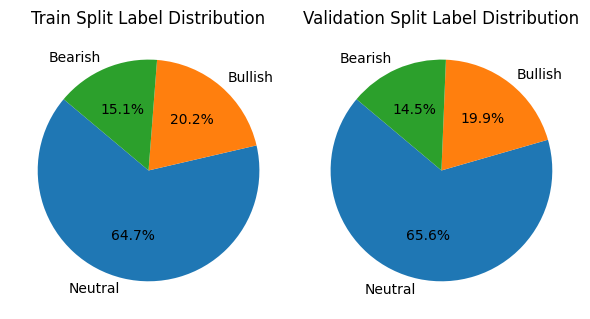

In [82]:

# Label counts for train split
train_label_counts = train_df['label'].value_counts()
train_labels = train_label_counts.index
train_counts = train_label_counts.values

# Label counts for validation split
validation_label_counts = validation_df['label'].value_counts()
validation_labels = validation_label_counts.index
validation_counts = validation_label_counts.values

# Plot pie chart for train split
plt.figure(figsize=(6, 6))

plt.subplot(1, 2, 1)
plt.pie(train_counts, labels=train_labels, autopct='%1.1f%%', startangle=140)
plt.title('Train Split Label Distribution')

# Plot pie chart for validation split
plt.subplot(1, 2, 2)
plt.pie(validation_counts, labels=validation_labels, autopct='%1.1f%%', startangle=140)
plt.title('Validation Split Label Distribution')

plt.tight_layout()
plt.show()


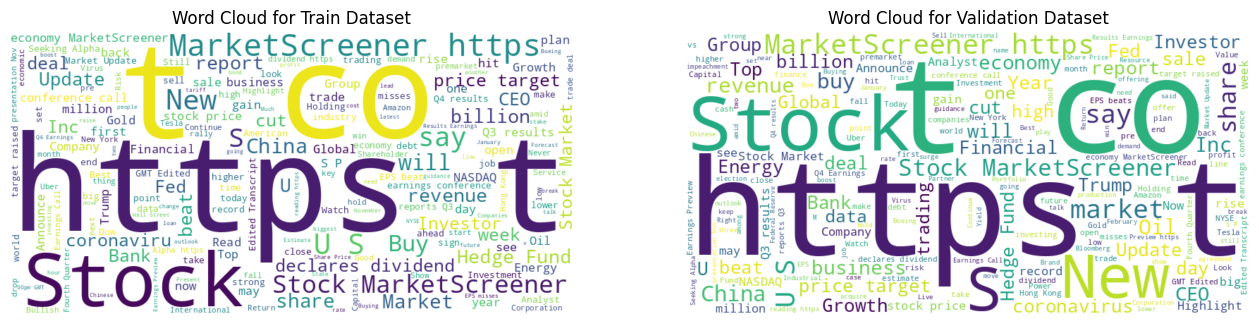

In [80]:


# Combine all the text data into one large string for the training dataset
train_text_data = ' '.join(train_df['text'])

# Combine all the text data into one large string for the validation dataset
validation_text_data = ' '.join(validation_df['text'])

# Create the word cloud object for the training dataset
train_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(train_text_data)

# Create the word cloud object for the validation dataset
validation_wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(validation_text_data)

# Plot the word clouds side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the word cloud for the training dataset
axs[0].imshow(train_wordcloud, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Word Cloud for Train Dataset')

# Plot the word cloud for the validation dataset
axs[1].imshow(validation_wordcloud, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Word Cloud for Validation Dataset')

plt.show()


PREPROCESSING

In [9]:
# Step 2: Initialize the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Step 3: Tokenize the data
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Apply the preprocessing function
tokenized_datasets = Twitter.map(preprocess_function, batched=True)

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

TRAINING AND FINE-TUNING

In [11]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy="epoch",     # evaluate after each epoch
    save_strategy="epoch",           # save model checkpoint after each epoch
    learning_rate=5e-5,              # learning rate
    per_device_train_batch_size=16,  # reduced batch size
    per_device_eval_batch_size=16,   # reduced evaluation batch size
    num_train_epochs=5,             # number of epochs
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy'
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Step 5: Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).astype(float).mean()}
)

In [13]:
# Step 6: Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.424400,0.418694,0.852596
2,0.260300,0.289866,0.900335
3,0.158200,0.400582,0.899497
4,0.176300,0.541986,0.897822
5,0.097000,0.570553,0.895729


TrainOutput(global_step=2985, training_loss=0.2347495964821896, metrics={'train_runtime': 2578.7823, 'train_samples_per_second': 18.503, 'train_steps_per_second': 1.158, 'total_flos': 1.255445672689152e+16, 'train_loss': 0.2347495964821896, 'epoch': 5.0})

EVALUATION

In [59]:

pred = trainer.predict(tokenized_datasets['validation'])
true = tokenized_datasets['validation']['label']

In [60]:
pred = pred.predictions.argmax(axis=-1)

In [61]:
confusion_matrix(true,pred)

array([[ 285,    9,   53],
       [  11,  416,   48],
       [  50,   67, 1449]])

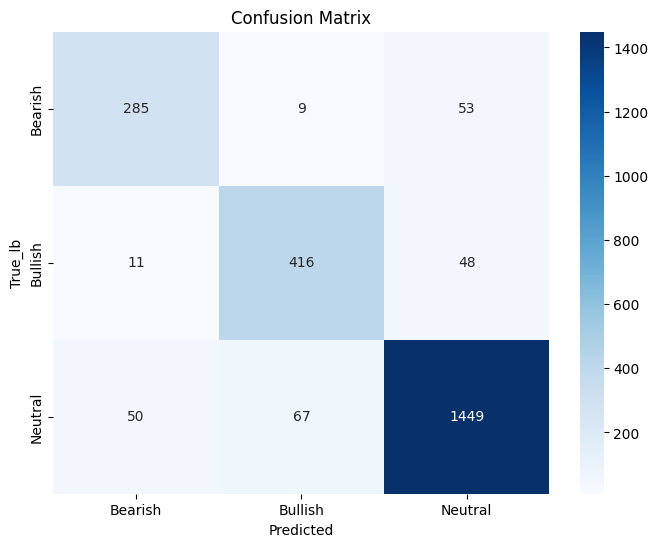

In [77]:
# Compute confusion matrix
cm = confusion_matrix(true, pred)

# Define the label mapping
labels = ['Bearish', 'Bullish', 'Neutral']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True_lb')
plt.title('Confusion Matrix')
plt.show()


In [78]:
print(classification_report(true,pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       347
           1       0.85      0.88      0.86       475
           2       0.93      0.93      0.93      1566

    accuracy                           0.90      2388
   macro avg       0.87      0.87      0.87      2388
weighted avg       0.90      0.90      0.90      2388



PREDICTION ON DIFFERENT EXAMPLES


In [86]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the appropriate device
model.to(device)

# Example tweets
example_tweets = ["$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT.",
"$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3.",
"$WING - Baird returns to Wingstop bull camp https://t.co/KfPaweOVgo",
"Analysts React To FCC Decision On Intelsat C-Band Spectrum Auction.",
"$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N",
"$ANCUF: BMO Capital Markets ups to Outperform",
"Bull camp empty on Sally Beauty",
"stock is booming"
]

# Tokenize the example tweets
encoded_inputs = tokenizer(example_tweets, padding=True, truncation=True, return_tensors='pt')

# Move the input tensors to the same device as the model
encoded_inputs = {key: value.to(device) for key, value in encoded_inputs.items()}

# Generate predictions
with torch.no_grad():
    logits = model(**encoded_inputs).logits

# Convert logits to probabilities
predictions = torch.softmax(logits, dim=-1)

# Get the predicted class for each tweet
predicted_classes = predictions.argmax(dim=-1)

# Define label mapping
label_mapping = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}

# Map the predicted classes to labels
predicted_labels = [label_mapping[int(pred)] for pred in predicted_classes]

# Display the predictions
for tweet, label in zip(example_tweets, predicted_labels):
    print(f"Tweet: '{tweet}' --> Sentiment: {label}")


Tweet: '$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT.' --> Sentiment: Bearish
Tweet: '$CCL $RCL - Nomura points to bookings weakness at Carnival and Royal Caribbean https://t.co/yGjpT2ReD3.' --> Sentiment: Bearish
Tweet: '$WING - Baird returns to Wingstop bull camp https://t.co/KfPaweOVgo' --> Sentiment: Bullish
Tweet: 'Analysts React To FCC Decision On Intelsat C-Band Spectrum Auction.' --> Sentiment: Neutral
Tweet: '$ESS: BTIG Research cuts to Neutral https://t.co/MCyfTsXc2N' --> Sentiment: Bearish
Tweet: '$ANCUF: BMO Capital Markets ups to Outperform' --> Sentiment: Bullish
Tweet: 'Bull camp empty on Sally Beauty' --> Sentiment: Neutral
Tweet: 'stock is booming' --> Sentiment: Bullish
